In [ ]:
# default_exp samplers.circuit_samplers

# Circuit Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction circuits

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition, make_hash, unpack
from qsam.fault_generators import Depolar
import qsam.samplers.callbacks as cb
from qsam.samplers.constants import *
from qsam.samplers.subset_helper import *

import numpy as np
import itertools as it
from tqdm.notebook import tqdm

In [ ]:
#export
class Sampler:
    def __init__(self, circuit, simulator):
        self.circuit = circuit
        self.simulator = simulator
        self.n_qubits = circuit.n_qubits
        self.is_setup = False
        
    def setup(self, sample_range, err_params):
        self.partitions = [partition(self.circuit, GATE_GROUPS[k]) for k in err_params.keys()]
        self.p_phys = [s * np.array(list(err_params.values())) for s in sample_range]
        
        self.cnts = np.zeros(len(sample_range))
        self.fail_cnts = np.zeros(len(sample_range))
        self.is_setup = True
        
    def stats(self, p_idx=None, var_fn=math.Wilson_var, **kwargs):
        if p_idx == None:
            rate = self.fail_cnts / self.cnts
            var = var_fn(rate, self.cnts)
        else:
            rate = self.fail_cnts[p_idx] / self.cnts[p_idx]
            var = var_fn(rate, self.cnts[p_idx])
            
        return rate, np.sqrt(var), 0.0
        
    def run(self, n_samples, callbacks=[]):
        assert self.is_setup, 'Sampler not setup. Call setup(..) before run(..).'
        
        if not isinstance(callbacks, cb.CallbackList):
            callbacks = cb.CallbackList(sampler=self, callbacks=callbacks)       
        callbacks.on_sampler_begin()
        
        for i, p_phy in enumerate(tqdm(self.p_phys, desc='Total')): 
            self.stop_sampling = False
            self.p_idx = i
            
            for _ in tqdm(range(n_samples), desc=f'p_phy={",".join(list(f"{p:.2E}" for p in p_phy))}', leave=True):
                sim = self.simulator(self.n_qubits)
                faults = Depolar.faults_from_probs(self.partitions, p_phy)
                fault_circuit = Depolar.gen_circuit(len(self.circuit), faults)
                msmt = sim.run(self.circuit, fault_circuit)
                if int(msmt,2) in fail_patterns:
                    self.fail_cnts[i] += 1
                self.cnts[i] += 1
                
                callbacks.on_circuit_end(locals())
                if self.stop_sampling: break
                
        callbacks.on_sampler_end()

Test sampler on GHZ circuit

In [ ]:
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

At runtime the measurements in a circuit will be composed to a bitstring of their outcomes and occurence in the circuit which is afterwards compared to the binary representation of all integers in `fail_patterns`. If one element matches, a logical failure is counted.

Total:   0%|          | 0/10 [00:00<?, ?it/s]

p_phy=1.00E-03:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=2.15E-03:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=4.64E-03:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=1.00E-02:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=2.15E-02:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=4.64E-02:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=1.00E-01:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=2.15E-01:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=4.64E-01:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=1.00E+00:   0%|          | 0/1000 [00:00<?, ?it/s]

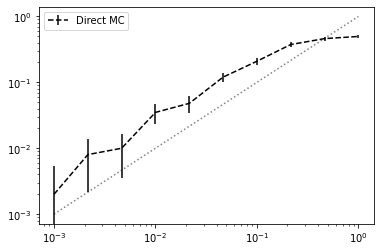

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}
fail_patterns = {1}

mc_sam = Sampler(ghz, CHP)
mc_sam.setup(sample_range, err_params)

callbacks = [
    cb.PlotStats(sample_range)
]
mc_sam.run(n_samples=1000, callbacks=callbacks)

In [ ]:
#export

class SubsetSampler:
    def __init__(self, circuit, simulator):
        self.circuit = circuit
        self.simulator = simulator
        self.n_qubits = circuit.n_qubits
        self.is_setup = False
        
    def setup(self, sample_range, err_params, w_max, w_exclude={}, p_max=0.1):
        p_max = np.array([p_max]) if isinstance(p_max, float) else np.array(p_max)
        assert len(p_max) == len(err_params)
        self.partitions = circuit_partitions(self.circuit, err_params.keys())
        self.w_vecs = circuit_weight_vectors(w_max, w_exclude)
        self.err_params = err_params
        self.w_max = w_max
        self.Aws_pmax = circuit_subset_occurence(self.partitions, self.w_vecs, p_max)
        self.Aws_pmax_inclusive = circuit_subset_occurence(self.partitions, circuit_weight_vectors(self.w_max), p_max)
        self.set_range(sample_range)
        
        self.cnts = np.zeros((len(self.w_vecs))) + 1 # one virtual sample to avoid div0
        self.fail_cnts = np.zeros((len(self.w_vecs)))
        self.is_setup = True
        
    def set_range(self, sample_range):
        p_phy_per_partition = np.array([[p_phy * mul for p_phy in sample_range] for mul in self.err_params.values()]).T
        self.Aws = circuit_subset_occurence(self.partitions, self.w_vecs, p_phy_per_partition)
        self.Aws_inclusive = circuit_subset_occurence(self.partitions, circuit_weight_vectors(self.w_max,{}), p_phy_per_partition)
        
    @property
    def ss_rate(self):
        cnts = self.cnts - 1 if np.all(self.cnts > 1) else self.cnts
        return ( self.fail_cnts / (cnts) )[:,None]
    
    def stats(self, const='Aws', var_fn=math.Wilson_var, **kwargs):
        if const == 'Aws': Aws, Aws_inclusive = self.Aws, self.Aws_inclusive
        elif const == 'Aws_pmax': Aws, Aws_inclusive = self.Aws_pmax[:,None], self.Aws_pmax_inclusive[:,None]
        v_L = np.sum( [Aws[w]**2 * var_fn(self.ss_rate[w], self.cnts[w]) for w in range(len(self.w_vecs))], axis=0 )
        p_L = np.sum(Aws * self.ss_rate, axis=0)
        if isinstance(v_L, np.ndarray) and isinstance(p_L, int): 
            p_L = np.zeros_like(v_L)
        delta = 1 - np.sum(Aws_inclusive, axis=0)
        return p_L, np.sqrt(v_L), delta
         
    def run(self, n_samples, callbacks=[]):
        assert self.is_setup, 'Sampler not setup. Call setup(..) before run(..).'
        
        if not isinstance(callbacks, cb.CallbackList):
            callbacks = cb.CallbackList(sampler=self, callbacks=callbacks)
            
        self.stop_sampling = False
        callbacks.on_sampler_begin()
        
        for i in tqdm(range(n_samples), desc='Total'):
            
            callbacks.on_circuit_begin()
            
            sim = self.simulator(self.n_qubits)
            w_idx = self.cnts.argmin() # balanced weight selector
            w_vec = self.w_vecs[w_idx]
            faults = Depolar.faults_from_weights(self.partitions, w_vec)
            fault_circuit = Depolar.gen_circuit(len(self.circuit), faults)
            msmt = sim.run(self.circuit, fault_circuit)
            if int(msmt,2) in fail_patterns:
                self.fail_cnts[w_idx] += 1
            self.cnts[w_idx] += 1
            
            callbacks.on_circuit_end(locals())
            if self.stop_sampling: break
        
        callbacks.on_sampler_end()

Total:   0%|          | 0/500 [00:00<?, ?it/s]

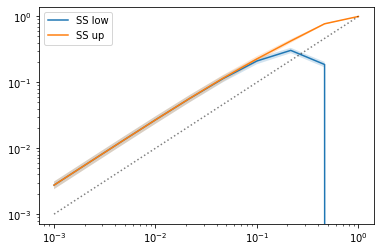

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}
fail_patterns = {1}

sb_sam = SubsetSampler(ghz, CHP)
sb_sam.setup(sample_range, err_params, w_max=[2], w_exclude={0})

callbacks = [
    cb.PlotStats(sample_range)
]
sb_sam.run(500, callbacks=callbacks)

Plot and compare to direct `Sampler`.

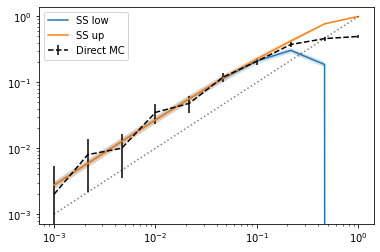

In [ ]:
#slow
#hide_input

import matplotlib.pyplot as plt

p_L, std, _ = mc_sam.stats()
p_L_low, ss_std, delta = sb_sam.stats()
p_L_up = p_L_low + delta

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(sample_range, p_L_low, label="SS low")
plt.fill_between(sample_range, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(sample_range, p_L_up, label="SS up")
plt.fill_between(sample_range, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(sample_range, sample_range, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

We can also easily change the sampling range of the subset sampler and replot:

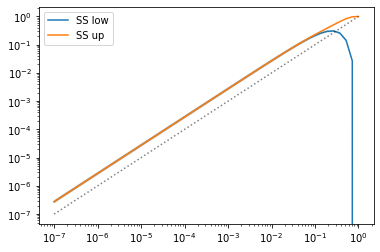

In [ ]:
#slow
sample_range = np.logspace(-7,0,50)
sb_sam.set_range(sample_range)
p_L_low, ss_std, delta = sb_sam.stats()
p_L_up = p_L_low + delta

import matplotlib.pyplot as plt

plt.plot(sample_range, p_L_low, label="SS low")
plt.fill_between(sample_range, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(sample_range, p_L_up, label="SS up")
plt.fill_between(sample_range, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(sample_range, sample_range, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

We can plot the occurence probabilities for each subset as a function of the physical error rate:

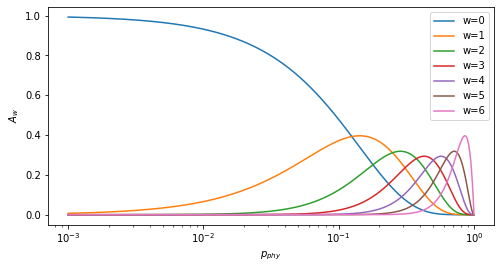

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

part = partition(ghz, GATE_GROUPS['p'])
Aw = np.array([[math.binom(w, len(part)+1, p) for p in p_phy] for w in range(len(part)+1)])
plt.figure(figsize=(8,4))
plt.plot(p_phy, Aw.T, label=[f'w={i}' for i in range(len(part)+1)]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

The `w=0` fault-weight subset occurs by far most often for smaller rates. However, for this subset we know in advance that no logical failure can occur. Thus, we gain a lot by excluding it from the sampling process. Futhermore, for fault-tolerant circuits, we can be sure that also a sampling from the `w=1` subsets will not cause a logical error by definition of fault tolerance. In these regions the `SubsetSampler` becomes far more efficient.

# Multi-parameter/partition noise
It is more realistic to give the different partitions, i.e. 1-qubit or 2-qubit gates etc. different physical error rates. Similarly to the single-parameter case we can take a look at the occurance of the 2-partition-subsets:

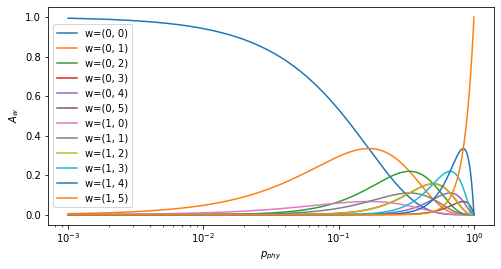

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

err_params = {'p1':p_phy, 'p2':p_phy}
partitions = [partition(ghz, GATE_GROUPS[g]) for g in err_params.keys()]
p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions
w_max_vec = [len(p) for p in partitions]
w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_max_vec]
w_vecs = list(it.product( *w_upto_w_maxs ))
Aws = subset_occurence(partitions, w_vecs, p_phys_mat)

plt.figure(figsize=(8,4))
plt.plot(p_phy, Aws.T, label=[f'w={i}' for i in w_vecs]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

As we can see the `(0,0)` subset has the largest impact for decreasing physical error rates. Thus we gain a lot by excluding it. This is how we run the subset sampler with multi-parameter noise and by manually excluding a subset.

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p1': 1, 'p2': 0.5}
fail_patterns = {1}

mc_sam = Sampler(ghz, CHP)
mc_sam.setup(sample_range, err_params)
mc_sam.run(1000)

sb_sam = SubsetSampler(ghz, CHP)
sb_sam.setup(sample_range, err_params, w_max=[1,3], w_exclude={(0,0)}, p_max=(0.1,0.1))
sb_sam.run(100)

Total:   0%|          | 0/10 [00:00<?, ?it/s]

p_phy=1.00E-03,5.00E-04:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=2.15E-03,1.08E-03:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=4.64E-03,2.32E-03:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=1.00E-02,5.00E-03:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=2.15E-02,1.08E-02:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=4.64E-02,2.32E-02:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=1.00E-01,5.00E-02:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=2.15E-01,1.08E-01:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=4.64E-01,2.32E-01:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=1.00E+00,5.00E-01:   0%|          | 0/1000 [00:00<?, ?it/s]

Total:   0%|          | 0/100 [00:00<?, ?it/s]

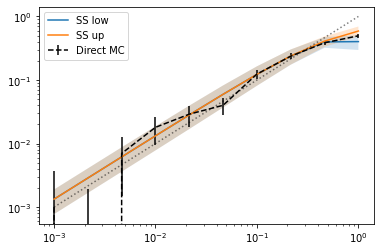

In [ ]:
#slow
#hide_input

import matplotlib.pyplot as plt

p_L, std, _ = mc_sam.stats()
p_L_low, ss_std, delta = sb_sam.stats()
p_L_up = p_L_low + delta

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(sample_range, p_L_low, label="SS low")
plt.fill_between(sample_range, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(sample_range, p_L_up, label="SS up")
plt.fill_between(sample_range, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(sample_range, sample_range, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

In [ ]:
#export
#hide

def calc_w_max(p_max, delta_max, n_partition_elems):
    """Calculate weight cutoff at p_max for delta_max"""
    
    delta = 1
    for w_max in range(n_partition_elems+1):
        delta -= math.binom(w_max, n_partition_elems, p_max)
        if delta < delta_max: 
            break
    return w_max

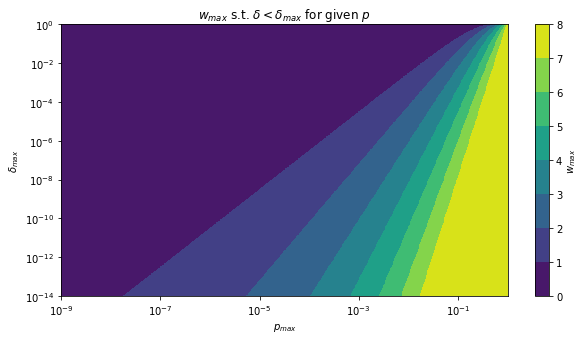

In [ ]:
#slow
#hide

n_gates = len(ghz)

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)

Z = [[calc_w_max(p_max, d_max, n_gates) for p_max in ps] for d_max in ds]

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{max}$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()